In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, linear_model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
import pydot
# %matplotlib inline

# Question I: Revisiting HW4 Bank Classication with New Tools (for dataset A) 

# I. Loading the dataset and performing data preprocessing

In [2]:
bank_addidtional_full = "bank-additional.csv"

data = pd.read_csv(bank_addidtional_full, sep = ';')
df = pd.DataFrame(data)
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
5,32,services,single,university.degree,no,no,no,cellular,sep,thu,...,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,no
6,32,admin.,single,university.degree,no,yes,no,cellular,sep,mon,...,4,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,no
7,41,entrepreneur,married,university.degree,unknown,yes,no,cellular,nov,mon,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
8,31,services,divorced,professional.course,no,no,no,cellular,nov,tue,...,1,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,no
9,35,blue-collar,married,basic.9y,unknown,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no


We first check for missing values in the dataset. The data is complete and there is no missing values

In [3]:
print(df.isnull().sum().sum())
print(df.shape)
df.info()

0
(4119, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4119 non-null object
marital           4119 non-null object
education         4119 non-null object
default           4119 non-null object
housing           4119 non-null object
loan              4119 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp.var.rate      4119 non-null float64
cons.price.idx    4119 non-null float64
cons.conf.idx     4119 non-null float64
euribor3m         4119 non-null float64
nr.employed       4119 non-null float64
y                 4119 non-null object
dtypes: float64(5), int64(5), object(11)
memory usage: 675.9+

Then we convert all the catogrical columns to numerical columns. Also, dropping the duration column since is a very predictive variable 

In [4]:
df.shape
df._get_numeric_data().head()
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df.drop(['duration'], axis=1, inplace=True)
df = pd.get_dummies(df,drop_first=True)
df.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,30,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,0,...,1,0,0,0,0,0,0,0,1,0
1,39,4,999,0,1.1,93.994,-36.4,4.855,5191.0,0,...,1,0,0,0,0,0,0,0,1,0
2,25,1,999,0,1.4,94.465,-41.8,4.962,5228.1,0,...,0,0,0,0,0,0,0,1,1,0
3,38,3,999,0,1.4,94.465,-41.8,4.959,5228.1,0,...,0,0,0,0,0,0,0,0,1,0
4,47,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,0,...,0,1,0,0,1,0,0,0,1,0


In [5]:
df.shape

(4119, 53)

In [6]:
cols = list(df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('y')) #Remove b from list
df = df[cols + ['y']] #Create new dataframe with columns in the order you want

According to UCI dataset description, the pdays columns (which represents the number of days passed by after the client was last contacted from a previous campaign) has some 999 values which means that client was not previously contacted. We replaced these 999 values with 0 since samples with 999 entries would be considered as an outliers when it comes to data cleaning. There was found to be 3,959 samples that in the pdays column that had to be replaced with 0 instead of 999



999    3959
3        52
6        42
4        14
7        10
10        8
12        5
5         4
2         4
9         3
1         3
13        2
18        2
16        2
15        2
0         2
14        1
19        1
21        1
17        1
11        1
Name: pdays, dtype: int64

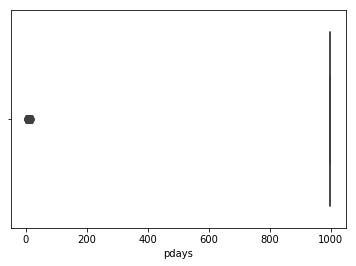

In [7]:
sns.boxplot(x=df['pdays'])
df['pdays'].value_counts()
# data['pdays'].isna().sum().sum()

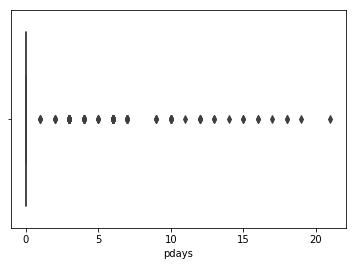

In [8]:
df.pdays = df.pdays.replace({999: 0 })
df[df['pdays'] == 999].count()
sns.boxplot(x=df['pdays'])

In [9]:
df['pdays'].value_counts()

0     3961
3       52
6       42
4       14
7       10
10       8
12       5
2        4
5        4
1        3
9        3
18       2
15       2
16       2
13       2
19       1
17       1
14       1
11       1
21       1
Name: pdays, dtype: int64

Now detecting the outliers and keeping samples that are only within 3 standard deviations

In [10]:
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

In [11]:
print(df.shape)
df.head()

(4119, 53)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,30,2,0,0,-1.8,92.893,-46.2,1.313,5099.1,1,...,0,0,0,0,0,0,0,1,0,0
1,39,4,0,0,1.1,93.994,-36.4,4.855,5191.0,0,...,0,0,0,0,0,0,0,1,0,0
2,25,1,0,0,1.4,94.465,-41.8,4.962,5228.1,0,...,0,0,0,0,0,0,1,1,0,0
3,38,3,0,0,1.4,94.465,-41.8,4.959,5228.1,0,...,0,0,0,0,0,0,0,1,0,0
4,47,1,0,0,-0.1,93.200,-42.0,4.191,5195.8,0,...,1,0,0,1,0,0,0,1,0,0


In [12]:
df['y'].value_counts()

0    3668
1     451
Name: y, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 53 columns):
age                              4119 non-null int64
campaign                         4119 non-null int64
pdays                            4119 non-null int64
previous                         4119 non-null int64
emp.var.rate                     4119 non-null float64
cons.price.idx                   4119 non-null float64
cons.conf.idx                    4119 non-null float64
euribor3m                        4119 non-null float64
nr.employed                      4119 non-null float64
job_blue-collar                  4119 non-null uint8
job_entrepreneur                 4119 non-null uint8
job_housemaid                    4119 non-null uint8
job_management                   4119 non-null uint8
job_retired                      4119 non-null uint8
job_self-employed                4119 non-null uint8
job_services                     4119 non-null uint8
job_student                      41

In [14]:
df.head(10)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,30,2,0,0,-1.8,92.893,-46.2,1.313,5099.1,1,...,0,0,0,0,0,0,0,1,0,0
1,39,4,0,0,1.1,93.994,-36.4,4.855,5191.0,0,...,0,0,0,0,0,0,0,1,0,0
2,25,1,0,0,1.4,94.465,-41.8,4.962,5228.1,0,...,0,0,0,0,0,0,1,1,0,0
3,38,3,0,0,1.4,94.465,-41.8,4.959,5228.1,0,...,0,0,0,0,0,0,0,1,0,0
4,47,1,0,0,-0.1,93.200,-42.0,4.191,5195.8,0,...,1,0,0,1,0,0,0,1,0,0
5,32,3,0,2,-1.1,94.199,-37.5,0.884,4963.6,0,...,0,0,1,0,1,0,0,0,0,0
6,32,4,0,0,-1.1,94.199,-37.5,0.879,4963.6,0,...,0,0,1,1,0,0,0,1,0,0
7,41,2,0,0,-0.1,93.200,-42.0,4.191,5195.8,0,...,1,0,0,1,0,0,0,1,0,0
8,31,1,0,1,-0.1,93.200,-42.0,4.153,5195.8,0,...,1,0,0,0,0,1,0,0,0,0
9,35,1,0,0,1.1,93.994,-36.4,4.855,5191.0,1,...,0,0,0,0,1,0,0,1,0,0


# II. Dividing data into training and testing

Splitting the data into train and test data. The test data size chosen to be 30%.

In [33]:
X = df.drop('y',axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=42)

# III. Applying classification: 

# a) Decision Tree

First, the classifier was instantiated with the default parameters and then was tuned later for comparison

In [16]:
dtree = DecisionTreeClassifier(random_state=100)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

Predincting and evaluating the model

In [17]:
predictions = dtree.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[998 107]
 [ 91  40]]


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1105
           1       0.27      0.31      0.29       131

   micro avg       0.84      0.84      0.84      1236
   macro avg       0.59      0.60      0.60      1236
weighted avg       0.85      0.84      0.84      1236



Area under curve (AUC) is plotted below to check for overfitting cases with depth of the tree

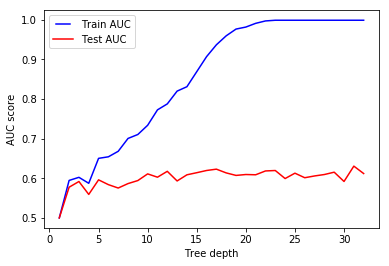

In [18]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

Based on the graph above, we see that when we have a high tree depth we get an overfitting case where the model can predicts the train data perfectly (high area under curve), however, the models fails to generalize and predict new data (test data)

In [21]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)

In [22]:
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [23]:
y_pred = clf_gini.predict(X_test)

In [24]:
print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

Accuracy is  90.77669902912622
[[1097    8]
 [ 106   25]]


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1105
           1       0.76      0.19      0.30       131

   micro avg       0.91      0.91      0.91      1236
   macro avg       0.83      0.59      0.63      1236
weighted avg       0.90      0.91      0.88      1236



In [25]:
# min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
# train_results = []
# test_results = []
# for min_samples_split in min_samples_splits:
#    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
#    dt.fit(X_train, y_train)
#    train_pred = dt.predict(X_train)
#    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    train_results.append(roc_auc)
#    y_pred = dt.predict(X_test)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    test_results.append(roc_auc)
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
# line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('min samples split')
# plt.show()

In [26]:
# min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
# train_results = []
# test_results = []
# for min_samples_leaf in min_samples_leafs:
#    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
#    dt.fit(X_train, y_train)
#    train_pred = dt.predict(X_train)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    train_results.append(roc_auc)
#    y_pred = dt.predict(X_test)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    test_results.append(roc_auc)
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
# line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('min samples leaf')
# plt.show()

Tree Visualization using the the built-in visualization from Scikit learn. This requires to install the pydot library and Graphviz.

In [27]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(X_train.columns)

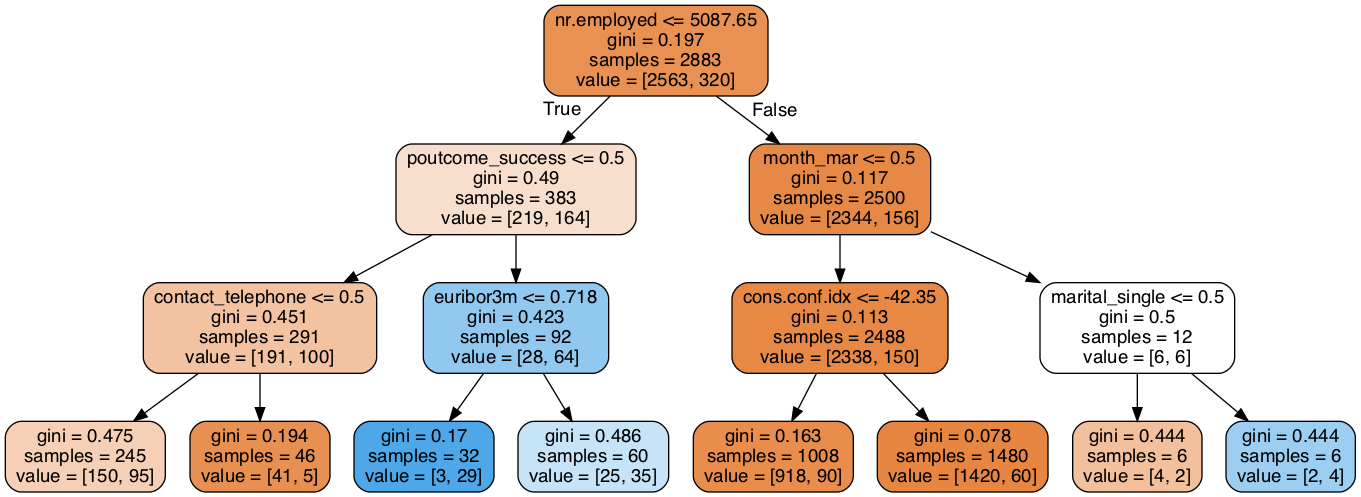

In [28]:
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

# b) Random Forests (RF)

We will first fit the model with default parameters and evaluate the performance, then we will tune the parameters and compare the performance. 

In [109]:
rfc = RandomForestClassifier(random_state=101)
rfc.fit(X_train, y_train)

/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [110]:
rfc_pred = rfc.predict(X_test)

In [111]:
print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))

[[1080   25]
 [  96   35]]


              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1105
           1       0.58      0.27      0.37       131

   micro avg       0.90      0.90      0.90      1236
   macro avg       0.75      0.62      0.66      1236
weighted avg       0.88      0.90      0.89      1236



Similar to DT classifier, we will use the area under curve AUC to evaluate the model. 

In [112]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

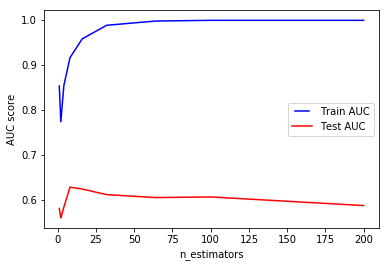

In [113]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1, random_state=101)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

    
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
# n = pd.DataFrame(test_results, n_estimators,columns=["n_estimators"])
# print(n['n_estimators'].max())
# n

The n_estimators in the random forests classifier represents the numsber of trees used in the classifier. Based on the AUC graph above, we see that the highest AUC score for the test data will be around 16 n_estimators. Increasing the n_estimators decreases the test perfomance. 

/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureW

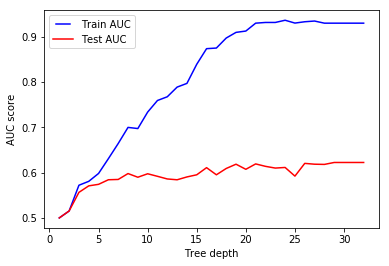

In [114]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, random_state=101)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that the higher the tree depth, we get an overfitting case. So a tree depth of 3 wil be chosen

In [121]:
RFC = RandomForestClassifier(n_estimators=16,random_state=101, max_depth=3)
RFC.fit(X_train, y_train)
RFC_pred = RFC.predict(X_test)

print("Results from the default parameters:")
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))
print('\n')
print("Results from the tunned parameters:")
print(confusion_matrix(y_test,RFC_pred))
print(classification_report(y_test,RFC_pred))

[[1080   25]
 [  96   35]]


              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1105
           1       0.58      0.27      0.37       131

   micro avg       0.90      0.90      0.90      1236
   macro avg       0.75      0.62      0.66      1236
weighted avg       0.88      0.90      0.89      1236



[[1102    3]
 [ 111   20]]


              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1105
           1       0.87      0.15      0.26       131

   micro avg       0.91      0.91      0.91      1236
   macro avg       0.89      0.57      0.61      1236
weighted avg       0.90      0.91      0.88      1236



# C) Neural Networks (NN)

Data should be normalized before training the neural network model. This is because the NN model might not converge before the max number of iterations allowed. Also, the multi-layer perception is sensitive to scaling the features. (source: https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2)



In [139]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [140]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [141]:
# Testing with 3 layers with same number of neurons to the number of features in the data set:(52)
mlp = MLPClassifier(random_state=101)

In [142]:
mlp.fit(X_train,y_train)

/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

predicting and evaluating

In [143]:
predictions = mlp.predict(X_test)

In [144]:
print(confusion_matrix(y_test,predictions))
print("\n")
print(classification_report(y_test,predictions))

[[1063   42]
 [ 100   31]]


              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1105
           1       0.42      0.24      0.30       131

   micro avg       0.89      0.89      0.89      1236
   macro avg       0.67      0.60      0.62      1236
weighted avg       0.86      0.89      0.87      1236



Tunning the NN parameters using the GridSearchCV method.

In [147]:
parameter_space = {
    'max_iter': [600],
    'hidden_layer_sizes': [(52,52,52), (50,100,50), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'random_state': [101]
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

In [149]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 600, 'random_state': 101, 'solver': 'sgd'}


In [154]:
y_true, y_pred = y_test , clf.predict(X_test)

print("Results from the default parameters:")
print("\n")
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("\n")
print("Results from the tunned parameters:")
print("\n")
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true, y_pred))


Results from the default parameters


[[1063   42]
 [ 100   31]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1105
           1       0.42      0.24      0.30       131

   micro avg       0.89      0.89      0.89      1236
   macro avg       0.67      0.60      0.62      1236
weighted avg       0.86      0.89      0.87      1236



Results from the tunned parameters


[[1084   21]
 [  99   32]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1105
           1       0.60      0.24      0.35       131

   micro avg       0.90      0.90      0.90      1236
   macro avg       0.76      0.61      0.65      1236
weighted avg       0.88      0.90      0.88      1236

